# Handwritten Digit Recognition with LeNet5 Model

In [ ]:
# Install necessary libraries
!pip install torch torchvision numpy

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
# Importing Necessary Libraries
import numpy as np
import struct
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Mount Google Drive to load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [ ]:
# Define a dataset class for EMNIST
class EMNISTDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.load_images(images_file)
        self.labels = self.load_labels(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def load_images(self, images_file):
        with open(images_file, 'rb') as f:
            magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
            images = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
        return images

    def load_labels(self, labels_file):
        with open(labels_file, 'rb') as f:
            magic, num_labels = struct.unpack('>II', f.read(8))
            labels = np.fromfile(f, dtype=np.uint8)
        return labels

In [ ]:
# Define paths to raw dataset files
train_images_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition/emnist-digits-train-images-idx3-ubyte'
train_labels_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition/emnist-digits-train-labels-idx1-ubyte'
test_images_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition/emnist-digits-test-images-idx3-ubyte'
test_labels_file = '/content/drive/MyDrive/Handwritten_Digit_Recognition/emnist-digits-test-labels-idx1-ubyte'

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Create datasets
train_dataset = EMNISTDataset(train_images_file, train_labels_file, transform=transform)
test_dataset = EMNISTDataset(test_images_file, test_labels_file, transform=transform)

In [ ]:
# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Sample Images Display

In [ ]:
# Function to display images
def show_images(images, labels, ncols=8):
    nrows = np.ceil(len(images) / ncols).astype(int)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 7))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i], cmap='gray')
            ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

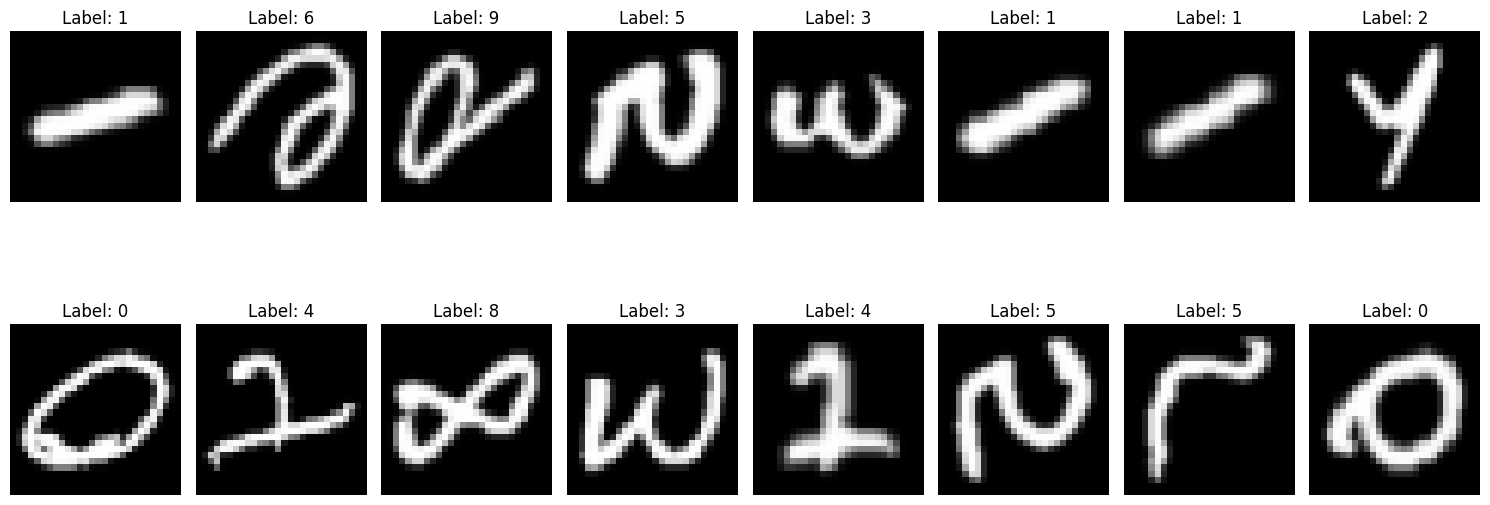

In [ ]:
# Display sample images from train dataset
sample_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
sample_images, sample_labels = next(iter(sample_loader))
sample_images = sample_images.numpy()

# Reshape images for plotting
sample_images = sample_images.reshape((-1, 28, 28))

# Show sample images
show_images(sample_images, sample_labels)

# Models Building

In [ ]:
# MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Training and Testing Functions

In [ ]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
# Function to test the model
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels)
            all_preds.extend(predicted)

    test_acc = correct / total
    print(f'Test Accuracy: {test_acc:.4f}')

    return test_acc, all_labels, all_preds

In [ ]:
# Instantiate models
mlp_model = MLP()
cnn_model = SimpleCNN()
lenet_model = LeNet5()

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_lenet = torch.optim.Adam(lenet_model.parameters(), lr=0.001)

# Models Training

In [ ]:
# Train MLP model
print("Training MLP model...")
mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs = train_model(mlp_model, train_loader, val_loader, criterion, optimizer_mlp, num_epochs=10)

Training MLP model...
Epoch [1/10], Train Loss: 0.1795, Train Acc: 0.9475, Val Loss: 0.0920, Val Acc: 0.9733
Epoch [2/10], Train Loss: 0.0810, Train Acc: 0.9756, Val Loss: 0.0764, Val Acc: 0.9764
Epoch [3/10], Train Loss: 0.0645, Train Acc: 0.9803, Val Loss: 0.0770, Val Acc: 0.9770
Epoch [4/10], Train Loss: 0.0561, Train Acc: 0.9828, Val Loss: 0.0676, Val Acc: 0.9799
Epoch [5/10], Train Loss: 0.0487, Train Acc: 0.9852, Val Loss: 0.0621, Val Acc: 0.9825
Epoch [6/10], Train Loss: 0.0450, Train Acc: 0.9862, Val Loss: 0.0628, Val Acc: 0.9822
Epoch [7/10], Train Loss: 0.0402, Train Acc: 0.9873, Val Loss: 0.0540, Val Acc: 0.9851
Epoch [8/10], Train Loss: 0.0383, Train Acc: 0.9881, Val Loss: 0.0507, Val Acc: 0.9864
Epoch [9/10], Train Loss: 0.0355, Train Acc: 0.9890, Val Loss: 0.0576, Val Acc: 0.9852
Epoch [10/10], Train Loss: 0.0336, Train Acc: 0.9897, Val Loss: 0.0652, Val Acc: 0.9828


In [ ]:
# Save the MLP model
model_path = "mlp_model.pth"
torch.save(mlp_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to mlp_model.pth


In [ ]:
# Train SimpleCNN model
print("Training SimpleCNN model...")
cnn_train_losses, cnn_val_losses, cnn_train_accs, cnn_val_accs = train_model(cnn_model, train_loader, val_loader, criterion, optimizer_cnn, num_epochs=10)

Training SimpleCNN model...
Epoch [1/10], Train Loss: 0.0762, Train Acc: 0.9774, Val Loss: 0.0390, Val Acc: 0.9887
Epoch [2/10], Train Loss: 0.0270, Train Acc: 0.9919, Val Loss: 0.0268, Val Acc: 0.9925
Epoch [3/10], Train Loss: 0.0203, Train Acc: 0.9940, Val Loss: 0.0269, Val Acc: 0.9925
Epoch [4/10], Train Loss: 0.0160, Train Acc: 0.9953, Val Loss: 0.0243, Val Acc: 0.9938
Epoch [5/10], Train Loss: 0.0129, Train Acc: 0.9961, Val Loss: 0.0224, Val Acc: 0.9942
Epoch [6/10], Train Loss: 0.0108, Train Acc: 0.9967, Val Loss: 0.0229, Val Acc: 0.9948
Epoch [7/10], Train Loss: 0.0094, Train Acc: 0.9971, Val Loss: 0.0256, Val Acc: 0.9940
Epoch [8/10], Train Loss: 0.0079, Train Acc: 0.9975, Val Loss: 0.0235, Val Acc: 0.9947
Epoch [9/10], Train Loss: 0.0071, Train Acc: 0.9978, Val Loss: 0.0328, Val Acc: 0.9935
Epoch [10/10], Train Loss: 0.0068, Train Acc: 0.9979, Val Loss: 0.0302, Val Acc: 0.9943


In [ ]:
# Save the Simple CNN model
model_path = "simple_cnn_model.pth"
torch.save(cnn_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to simple_cnn_model.pth


In [ ]:
# Train LeNet5 model
print("Training LeNet5 model...")
lenet_train_losses, lenet_val_losses, lenet_train_accs, lenet_val_accs = train_model(lenet_model, train_loader, val_loader, criterion, optimizer_lenet, num_epochs=10)

Training LeNet5 model...
Epoch [1/10], Train Loss: 0.1118, Train Acc: 0.9663, Val Loss: 0.0401, Val Acc: 0.9881
Epoch [2/10], Train Loss: 0.0371, Train Acc: 0.9889, Val Loss: 0.0338, Val Acc: 0.9903
Epoch [3/10], Train Loss: 0.0289, Train Acc: 0.9913, Val Loss: 0.0369, Val Acc: 0.9895
Epoch [4/10], Train Loss: 0.0244, Train Acc: 0.9927, Val Loss: 0.0263, Val Acc: 0.9928
Epoch [5/10], Train Loss: 0.0208, Train Acc: 0.9938, Val Loss: 0.0257, Val Acc: 0.9926
Epoch [6/10], Train Loss: 0.0181, Train Acc: 0.9945, Val Loss: 0.0274, Val Acc: 0.9924
Epoch [7/10], Train Loss: 0.0162, Train Acc: 0.9952, Val Loss: 0.0224, Val Acc: 0.9938
Epoch [8/10], Train Loss: 0.0147, Train Acc: 0.9956, Val Loss: 0.0248, Val Acc: 0.9932
Epoch [9/10], Train Loss: 0.0133, Train Acc: 0.9959, Val Loss: 0.0305, Val Acc: 0.9923
Epoch [10/10], Train Loss: 0.0121, Train Acc: 0.9962, Val Loss: 0.0268, Val Acc: 0.9937


In [ ]:
# Save the LeNet5 model
model_path = "lenet5_model.pth"
torch.save(lenet_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to lenet5_model.pth


# Model Testing

In [ ]:
# Test MLP model
print("Testing MLP model...")
mlp_test_acc, mlp_test_labels, mlp_test_preds = test_model(mlp_model, test_loader)

Testing MLP model...
Test Accuracy: 0.9828


In [ ]:
# Test SimpleCNN model
print("Testing SimpleCNN model...")
cnn_test_acc, cnn_test_labels, cnn_test_preds = test_model(cnn_model, test_loader)

Testing SimpleCNN model...
Test Accuracy: 0.9941


In [ ]:
# Test LeNet5 model
print("Testing LeNet5 model...")
lenet_test_acc, lenet_test_labels, lenet_test_preds = test_model(lenet_model, test_loader)

Testing LeNet5 model...
Test Accuracy: 0.9939


In [ ]:
# Print test accuracies
print(f"MLP Test Accuracy: {mlp_test_acc:.4f}")
print(f"Simple CNN Test Accuracy: {cnn_test_acc:.4f}")
print(f"LeNet-5 Test Accuracy: {lenet_test_acc:.4f}")

MLP Test Accuracy: 0.9828
Simple CNN Test Accuracy: 0.9941
LeNet-5 Test Accuracy: 0.9939


# Testing and Training Visualizations



In [ ]:
# Visualize accuracy and loss
def plot_metrics(train_accs, val_accs, train_losses, val_losses, title):
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

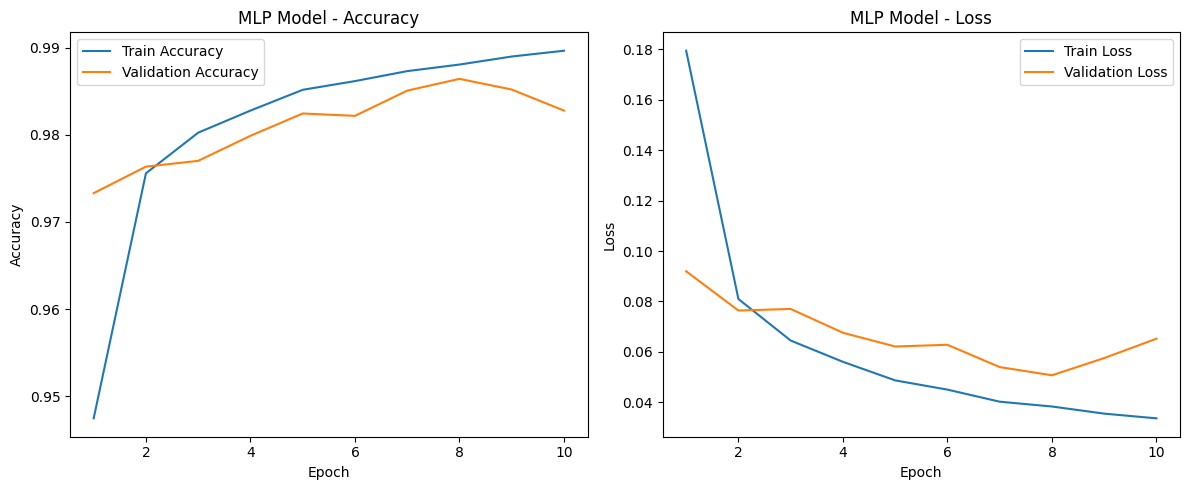

In [ ]:
# Plot metrics for MLP model
plot_metrics(mlp_train_accs, mlp_val_accs, mlp_train_losses, mlp_val_losses, 'MLP Model')

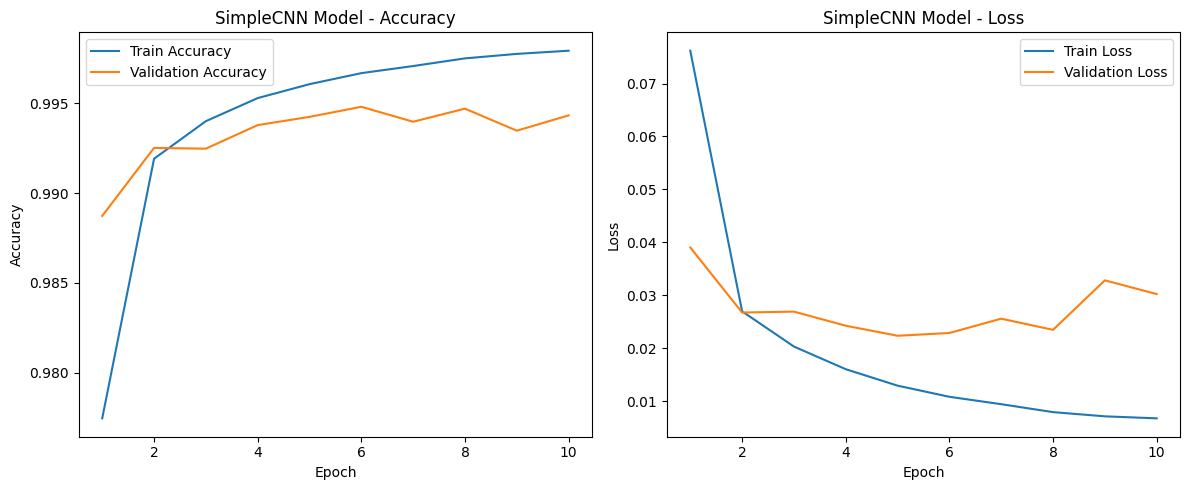

In [ ]:
# Plot metrics for SimpleCNN model
plot_metrics(cnn_train_accs, cnn_val_accs, cnn_train_losses, cnn_val_losses, 'SimpleCNN Model')

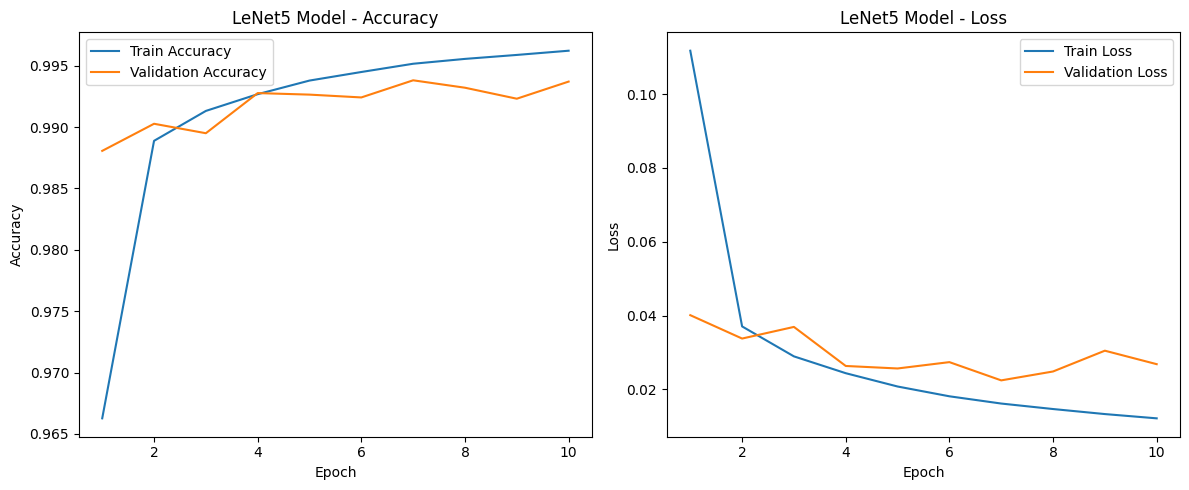

In [ ]:
# Plot metrics for LeNet5 model
plot_metrics(lenet_train_accs, lenet_val_accs, lenet_train_losses, lenet_val_losses, 'LeNet5 Model')

# Loading the Saved Model

In [ ]:
# Load the trained model weights
mlp_model.load_state_dict(torch.load('/content/drive/MyDrive/Handwritten_Digit_Recognition/Models/mlp_model.pth'))
cnn_model.load_state_dict(torch.load('/content/drive/MyDrive/Handwritten_Digit_Recognition/Models/simple_cnn_model.pth'))
lenet_model.load_state_dict(torch.load('/content/drive/MyDrive/Handwritten_Digit_Recognition/Models/lenet5_model.pth'))

<All keys matched successfully>

In [ ]:
# Evaluate models on test set
print("MLP Model Loading ")
mlp_test_acc, mlp_labels, mlp_preds = test_model(mlp_model, test_loader)
print("Simple CNN Model Loading ")
cnn_test_acc, cnn_labels, cnn_preds = test_model(cnn_model, test_loader)
print("LeNet 5 Model Loading ")
lenet_test_acc, lenet_labels, lenet_preds = test_model(lenet_model, test_loader)

MLP Model Loading 
Test Accuracy: 0.9828
Simple CNN Model Loading 
Test Accuracy: 0.9941
LeNet 5 Model Loading 
Test Accuracy: 0.9939


# Checking the Model Predictions

In [ ]:
# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# Function to display images with labels and predictions
def show_predictions(model, test_loader, num_images=8):
    model.eval()
    correct = 0
    total = 0

    fig, axes = plt.subplots(2, 4, figsize=(15, 7))
    axes = axes.flatten()

    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i >= num_images:
                break

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            axes[i].imshow(images[0][0], cmap='gray')  # Display the first image in the batch
            axes[i].set_title(f'True: {labels[0]}, Predicted: {predicted[0]}')
            axes[i].axis('off')

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    plt.tight_layout()
    plt.show()


Predictions for MLP Model:


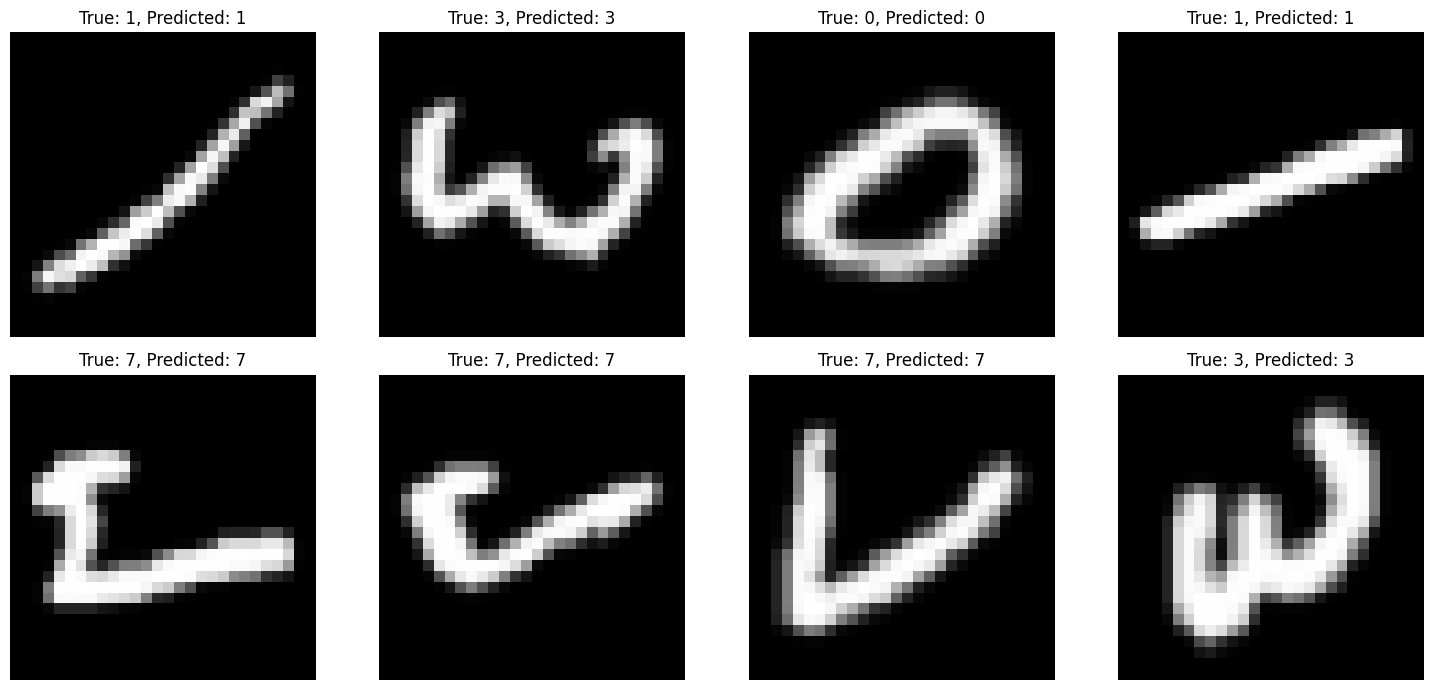

In [ ]:
# Show predictions for MLP model
print("Predictions for MLP Model:")
show_predictions(mlp_model, test_loader)

Predictions for SimpleCNN Model:


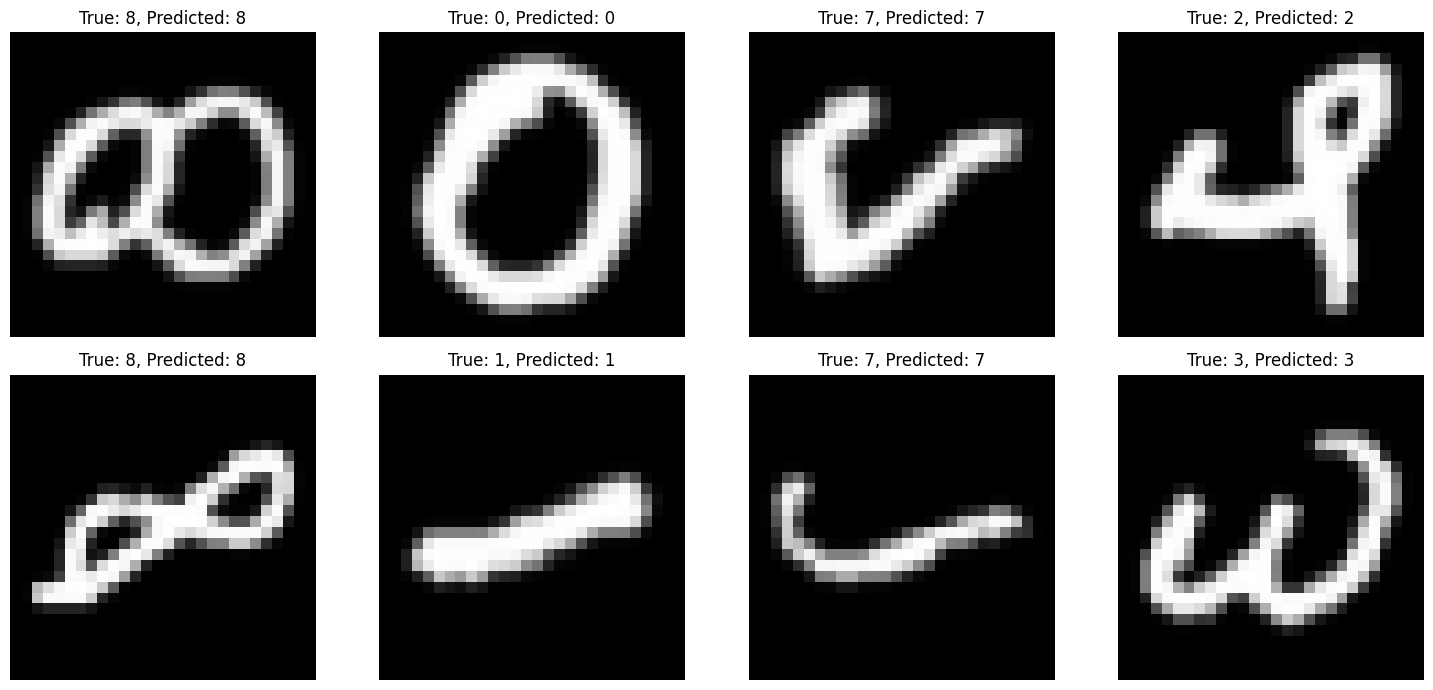

In [ ]:
# Show predictions for SimpleCNN model
print("Predictions for SimpleCNN Model:")
show_predictions(cnn_model, test_loader)

Predictions for LeNet-5 Model:


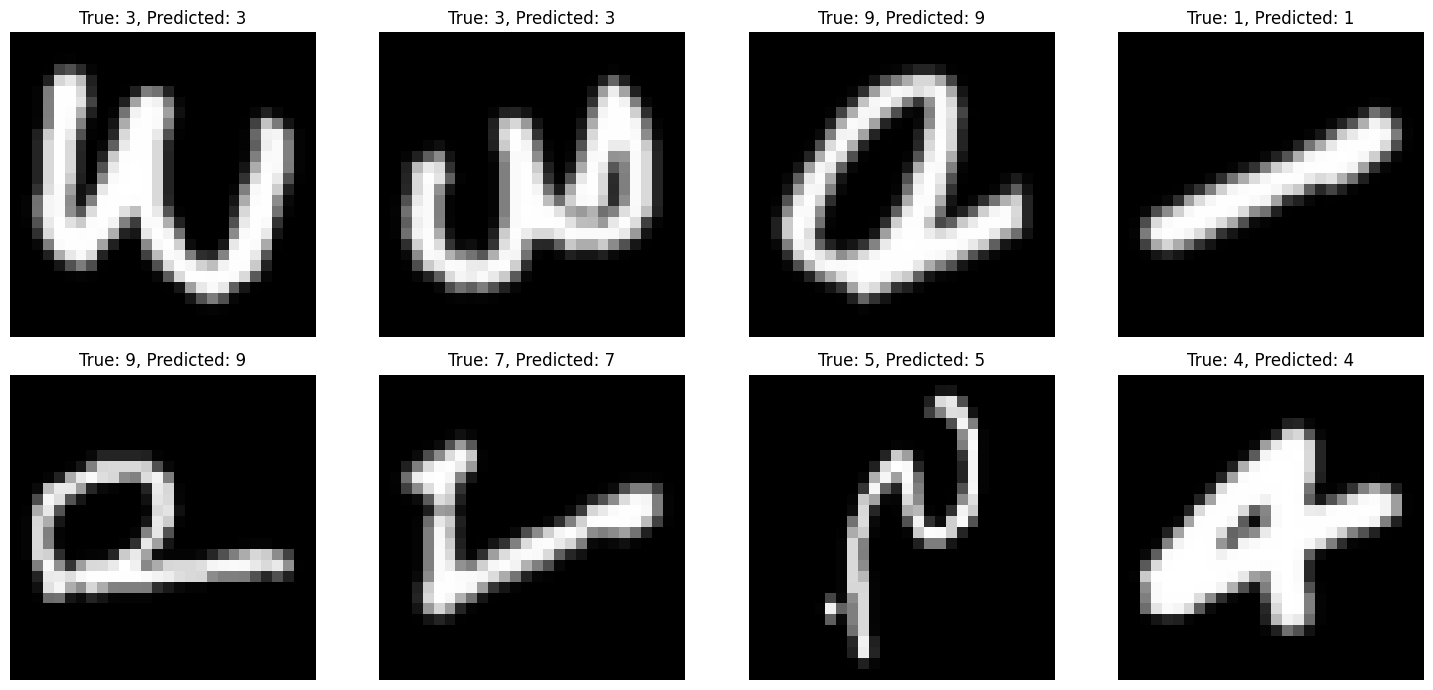

In [ ]:
# Show predictions for LeNet-5 model
print("Predictions for LeNet-5 Model:")
show_predictions(lenet_model, test_loader)